# Predicting On-time Delivery of Online Purchases
## AAI-510 Team 7 Final Project

Team 7:  Ken Devoe, Tyler Foreman, Geoffrey Fadera

University of San Diego, Applied Artificial Intelligence

Date:  June 24, 2024

GitHub Repository: https://github.com/kdevoe/aai510-group7

## Business Problem Statement and Approach

**Business Understanding**

SevenSeas, Inc. is an online retailer, selling a broad catalog of products through various e-commerce channels.  As a company operating at a global scale, SevenSeas ships direct to customers all over the world by air, sea and land.  Recently, there has been an uptick in customer complaints due to shipments not being delivered on time.  This has resulted in unhappy customers that have posted negative reviews online as well as an increase in returns and requests for refunds.

Company leadership has flagged this as an urgent issue to resolve.  Our data science team has been tasked to develop a method to better predict on-time delivery of products based on a combination of characteristics that describe the shipping medium and customer profile.  These predictions will need to be made prior to the package being prepared for shipment.  To facilitate this, the team has compiled a dataset of key characteristics that are known at the time of purchase.  These predictions will enable SevenSeas to adjust the shipping methods for those packages that are determined to be at risk of delayed shipment using standard methods and ensure that on-time delivery is improved.

The key objectives of this project are:

- Develop a machine learning model that can predict whether a package will be delivered on-time based on a set of characteristics known at the time of purchase.
- Determine which features of the shipping medium are contributing most to predicting delayed deliveries
 

**Approach**

Based on the team's business understanding of the business challenge and dataset, it was determined that the best way to frame this problem was as a supervised learning task to perform binary classification.  That is, the model would be trained on the labeled dataset to make binary predictions as to whether the shipment would be on-time (1) or late (0).  As such, the team seeks to experiment with several candidate classical machine learning model architectures that are suited for the binary classification task, evaluate their performance and select the model whose performance characteristics are best suited to solve the business challenge.

The team employed the following appraoch and evaluation criteria to develop the optimal solution to the problem:

- Conduct exploratory data analysis to determine the shape of the data, the cleanliness and perform initial evaluation on correlation of the features
- Prepare the dataset for modeling: clean missing data, encode categorical features, normalize numerical values
- Run training, hyperparameter tuning and performance evaluation of 6 classial supervised machine learning model architectures (all as classifiers):
    - Logistic Regression (baseline model)
    - Naive Bayes
    - Decision Tree
    - Random Forest
    - XGBoost 
    - Support Vector Machine
    - K-Nearest Neighbor

**Evaluation Criteria**

The primary business objective is to optimize the ability to accurately predict late delivery of packages.  It is critical to the business that the model does not incorrectly classify these shipments.  The evaluation criteria will therefore focus on optimizing for minimizing false positives (false on-time deliveries).  It is acceptable for the business to handle some rate of false alarms (false late deliveries) but these should be minimized as much as possible.

## Part I: Exploratory Data Analysis (EDA)

## Imports and Setup

### Imports

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from dataprep.eda import plot, plot_correlation, plot_missing, plot_diff, create_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Setup

In [4]:

DISPLAY_DATAPREP = False  # Dataprep can mess up display outputs, setting as off by default

plt.set_loglevel('WARNING')  # Reducing error messages

## Data Download and Overview

In [5]:
datafile = './data/shipping.csv'
TARGET = 'Reached.on.Time_Y.N'

df = pd.read_csv(datafile)

# Drop the ID column
df = df.drop(columns='ID')


display(df)

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...
10994,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,C,Ship,5,4,242,5,low,F,4,1155,0
10997,F,Ship,5,2,223,6,medium,M,2,1210,0


In [4]:
df.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


An overview of the products:

- $96 - $310 dollar value range
- 1 kg - 7.8 kg in weight (roughly 2 - 20 lbs)
- Discount between 1 and 65 (4 - 10 IQR). This seems to be percentage (later pairplot shows no trend with cost of product).

Seems like a specific category of products. Nothing very light like letters, nothing heavy like machinery. Narrow dollar range between $100 and $300 dollars, no high end electronics and no cheap items.

In [5]:
if DISPLAY_DATAPREP:
    plot(df)

## Missing Values

No values are missing from the dataset.

In [6]:
# Display the number of missing values per variable
display(df.isnull().sum())

Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

## Target Variable Distribution

The target variable of whether the shipment was on time or not does not show a significant class imbalance. Approximately 60% of the data is for shipments that reached on time, with the remaining 40% not arriving on time.

In [7]:
if DISPLAY_DATAPREP:
    plot(df, TARGET)

## Data Types

Of the 11 variables 7 are numerical and 4 are categorical. Categorical data will need to be encoded in some way before full analysis can be completed. Of the categorical data only product importance is ordinal (low, medium, high) and the remaining categorical variables do not have relative importance between their values.

In [8]:
# Plot the data types
data_types = df.dtypes
display(data_types)


Warehouse_block        object
Mode_of_Shipment       object
Customer_care_calls     int64
Customer_rating         int64
Cost_of_the_Product     int64
Prior_purchases         int64
Product_importance     object
Gender                 object
Discount_offered        int64
Weight_in_gms           int64
Reached.on.Time_Y.N     int64
dtype: object

## General Correlation between Variables

To compare general trends between variables a few different methods are used, including pairplot and a correlation matrix. Trends are then further investigated in the individual variable correlation section further below.

### Pairplot

A couple trends stand out from the pairplot:

- Both discount offered and weight in grams appear to have some correlation to the target variable of on-time shipments

- Weight in grams shows some interesting stratification patterns against cost of product and discount offered. 

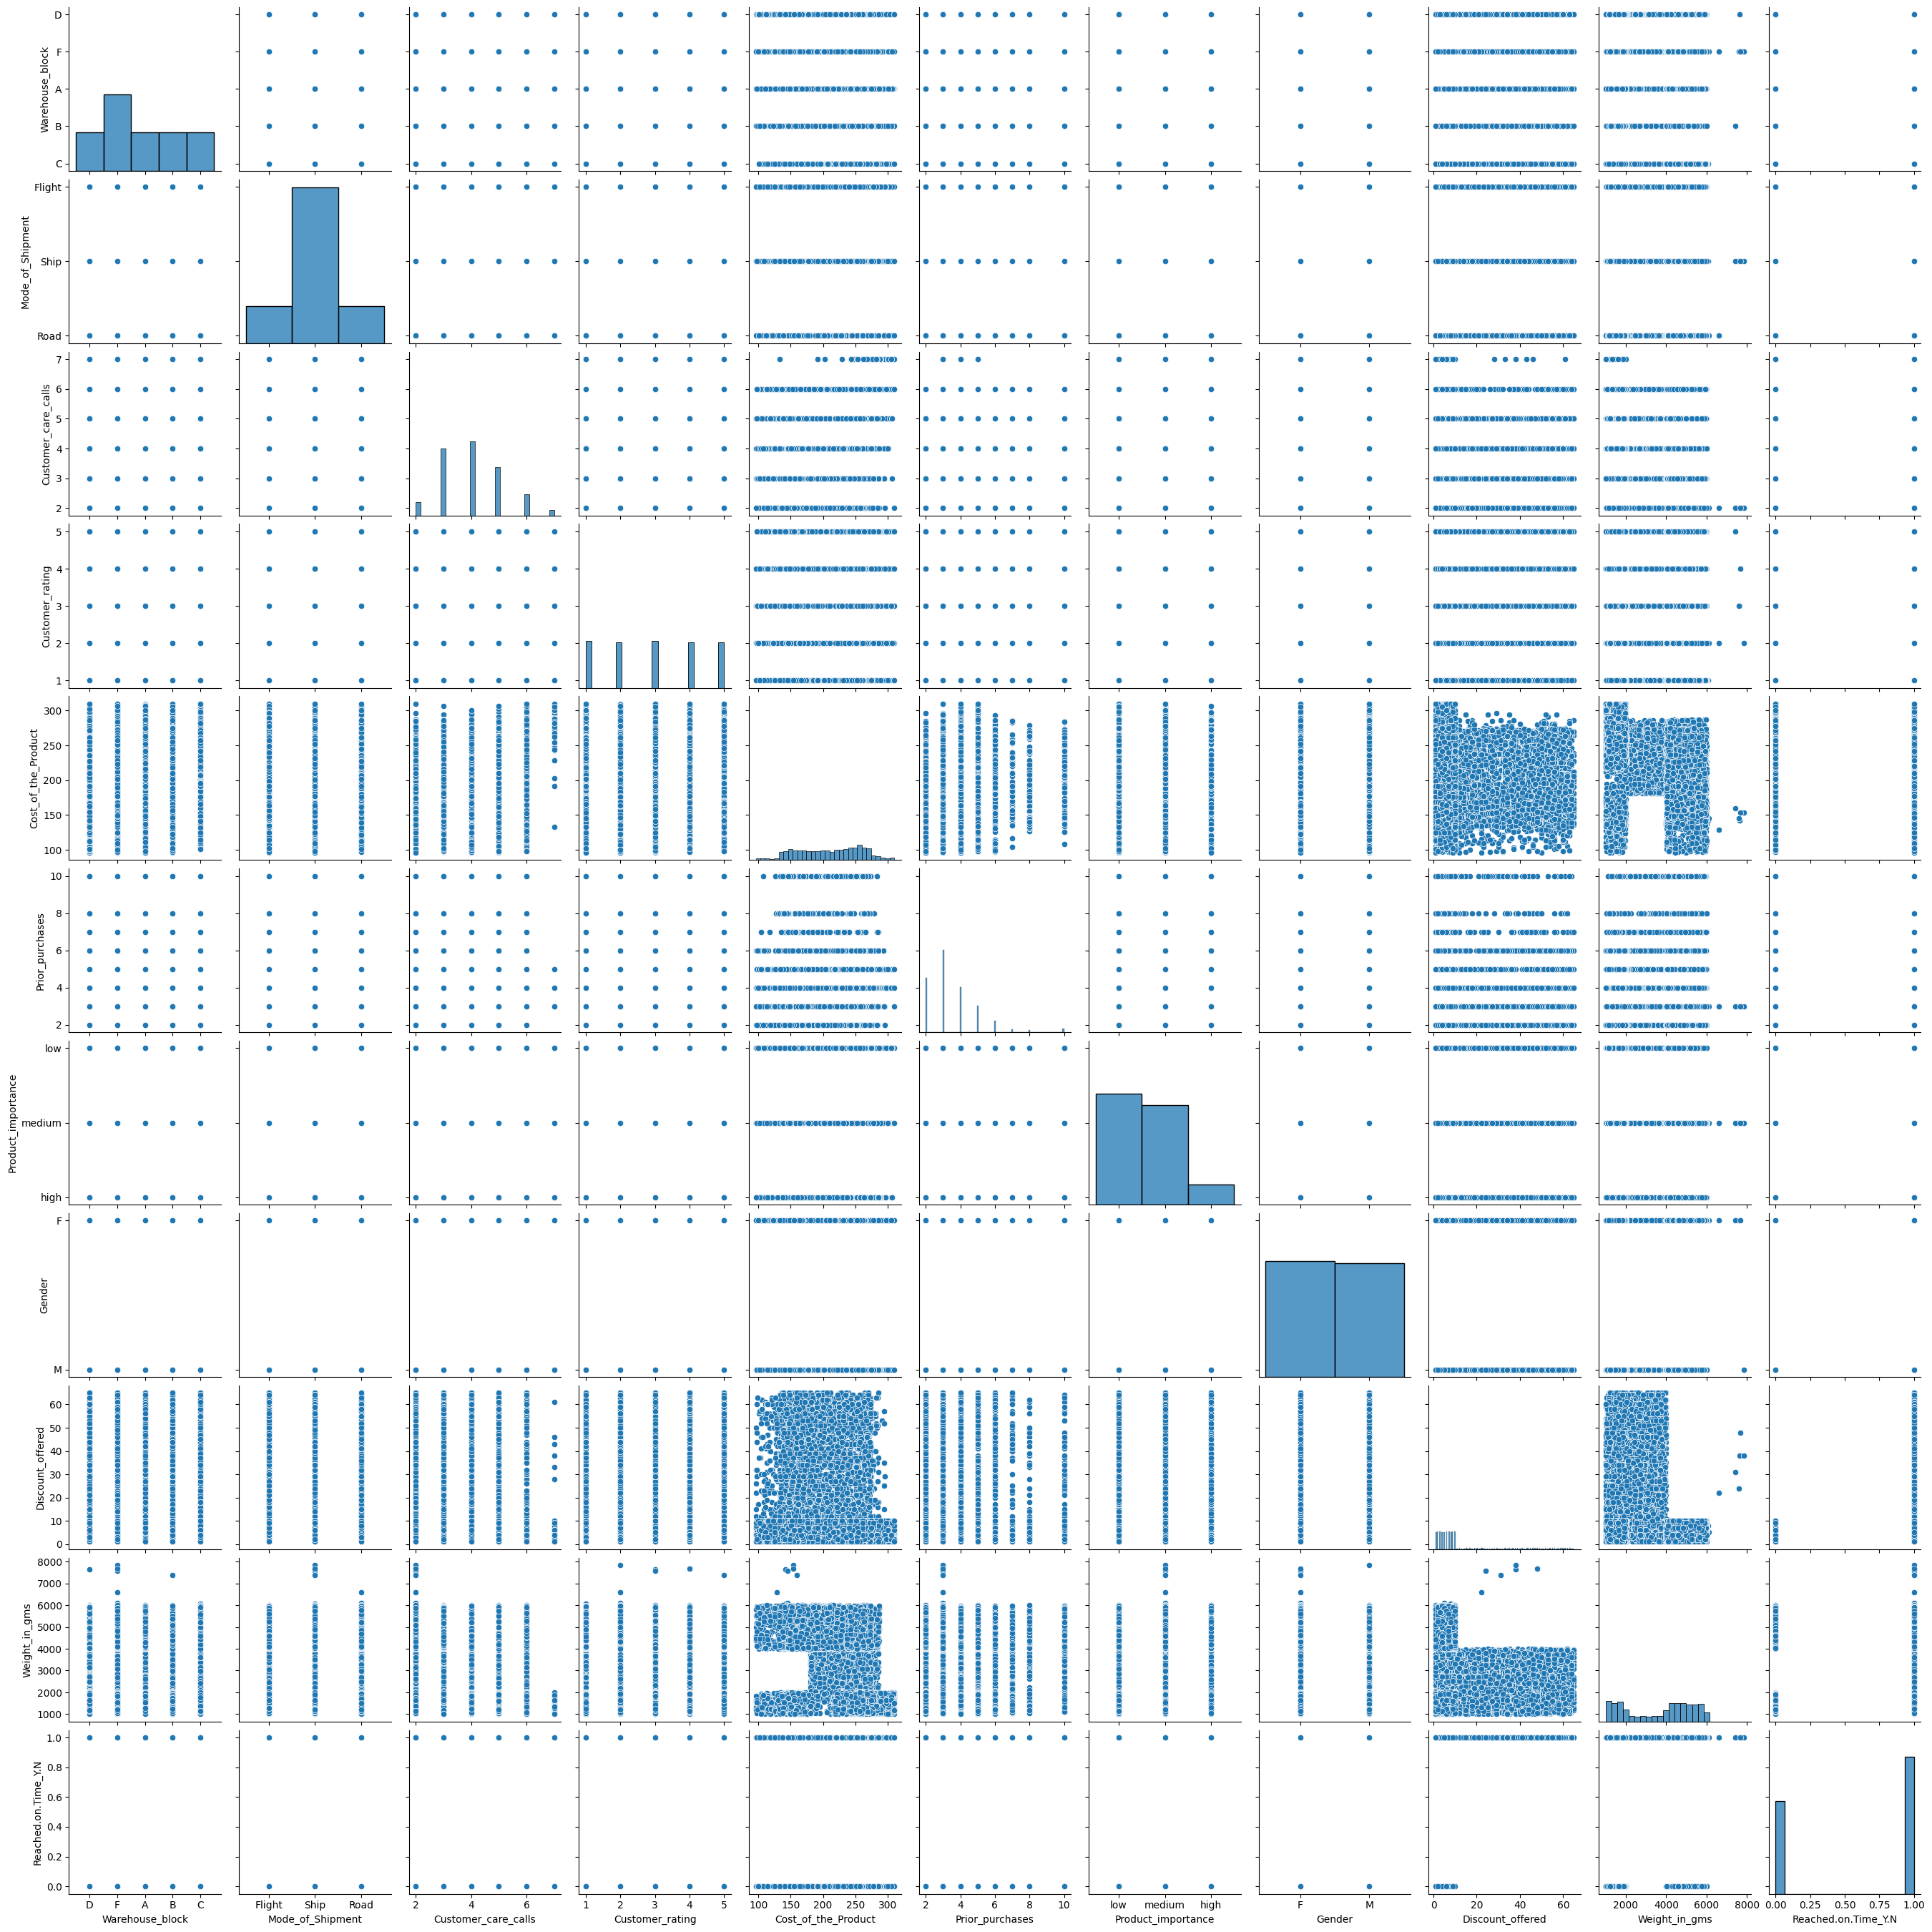

In [9]:
vars = df.columns
sns.pairplot(df, vars=vars)

plt.show()

### Correlation Matrix (One Hot Encoding)

As some variables are categorical and not ordinal one hot encoding was used to look at correlation. Overall this increases the number of variables from 11 to 20 and makes comparisons generally more difficult. 

Comparing the one hot encoded categorical data to variables outside the same category no significant trends appear. Since individual one-hot encoded categorical variables don't show strong trends they will be combined using label encoding and a more detailed analysis will be done on correlations in the next step.

<Axes: >

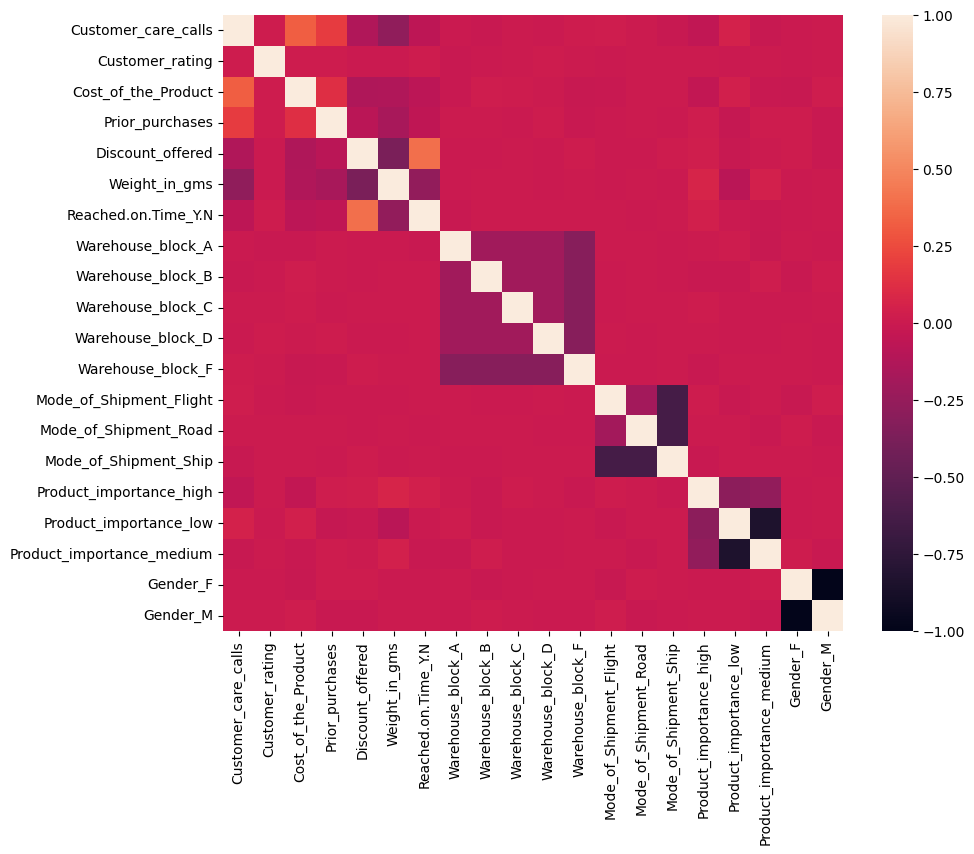

In [10]:
df_one_hot = pd.get_dummies(df)
plt.figure(figsize=(10, 8))
corr_one_hot = df_one_hot.corr()
sns.heatmap(corr_one_hot)

### Correlation Matrix (Label Encoding)

To keep the number of variables smaller label encoding was used to look at overall trends. In general a few significant trends were found. Using +/- 0.20 as an arbitrary cutoff the following correlations were observed:

- Discount Offered vs. Arrive on Time: This was the strongest trend at 0.40, indicating discount offered is going to be an important variable for models to use for preditions.
- Weight in Grams vs. Arrive on Time: Also a strong correlation with the target variable, lower product weights tend to arrive on time more often.
- Discount Offered vs. Weight in Grams: As the weight drops there is less likely to be a discount.
- Weight in Grams vs. Customer Care Calls: Higher weight means less customer care calls.
- Weight in Grams vs. Cost of Product: More heavy products tend to cost more, which intuitively makes sense.

All of these trends will be looked at in a more individual basis in the next section.

In [11]:

le = LabelEncoder()

df_label_encode = df.copy()

categorical_columns = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    df_label_encode[col] = le.fit_transform(df_label_encode[col])

<Axes: >

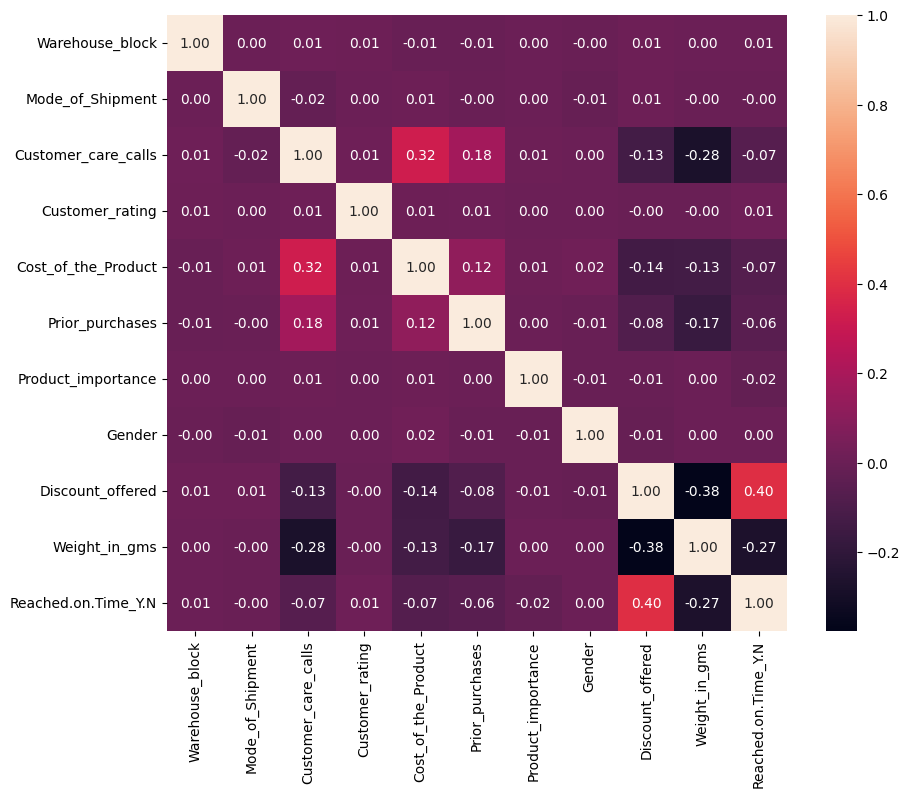

In [12]:
corr_label_encode = df_label_encode.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_label_encode, fmt='.2f', annot=True)

## Individual Correlations

A deeper look at the significant trends between variables.

### Discount Offered vs. Reached on Time

Products with higher discounts are much more likely to arrive on time. 

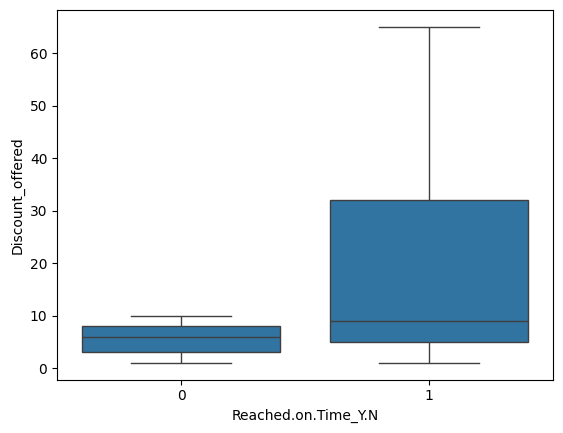

In [13]:
sns.boxplot(x=df[TARGET], y=df['Discount_offered'])
plt.show()

### Weight in Grams vs. Reached on Time

Comparing a boxplot shows the median value for weight of delayed shipments is higher, however there are a large number of low weight outliers, suggesting the data is bi-modal. 

Plotting the density shows that the weight in grams distribution is indeed bi-modal. What stands out is low weight products are more likely to arrive on time, and virtually no products between ~2.5 kg and ~3.5 kg are delayed.

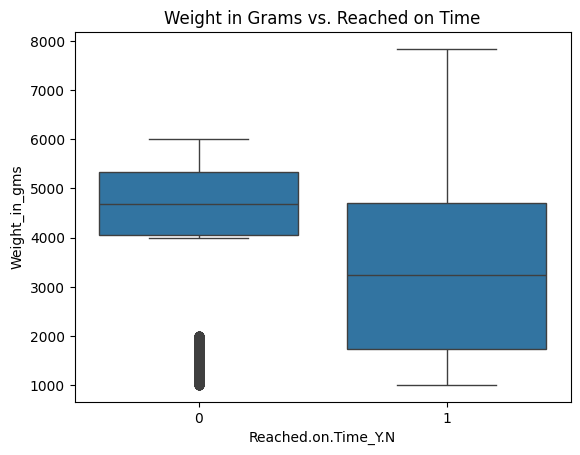

In [14]:
sns.boxplot(x=df[TARGET], y=df['Weight_in_gms'])
plt.title("Weight in Grams vs. Reached on Time")
plt.show()

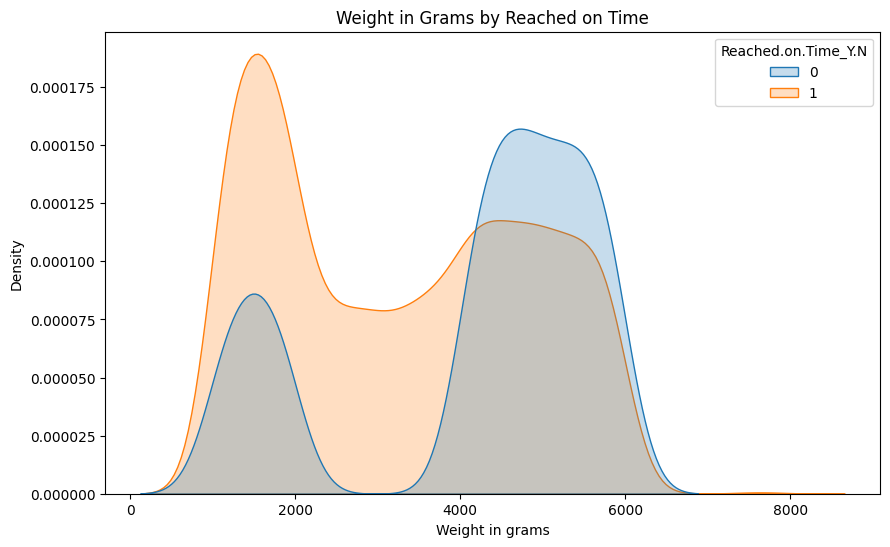

In [15]:
# Plot density plots
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Weight_in_gms', hue=TARGET, fill=True)
plt.title('Weight in Grams by Reached on Time')
plt.xlabel('Weight in grams')
plt.ylabel('Density')
plt.show()

### Discount Offered vs. Weight in Grams

It seems like there are specific ranges for discounts based on weight:
- 1kg - 4kg: 0 - 65 % discount
- 4kg - 6kg: 0 - 10 % discount
- 6kg+ : Very few products and no trend

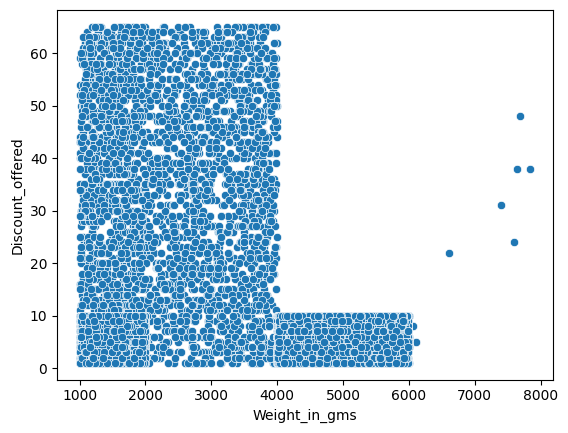

In [16]:
sns.scatterplot(data=df, x='Weight_in_gms', y='Discount_offered')
plt.show()

### Weight in Grams vs. Customer Care Calls

Lighter packages have less customer care calls. This is not expected, as heavier packages are more likely to be delayed.

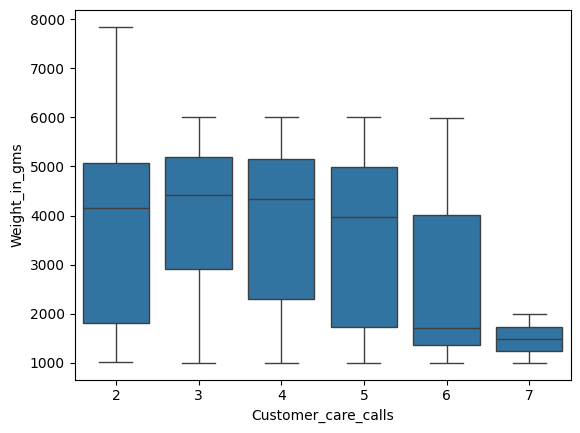

In [17]:
sns.boxplot(data=df, y='Weight_in_gms', x='Customer_care_calls')
plt.show()

### Cost of Product vs. Customer Care Calls

Higher cost products have more customer care calls as expected.

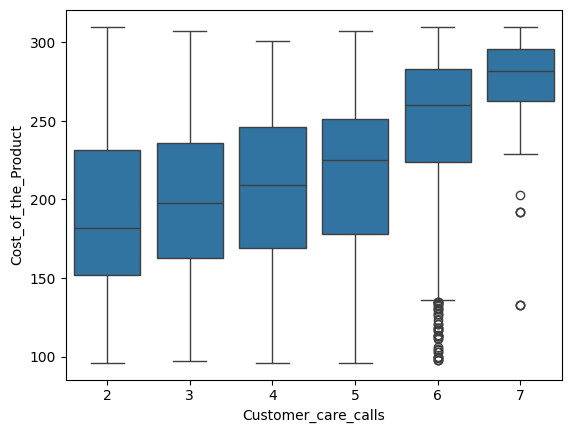

In [18]:
sns.boxplot(data=df, y='Cost_of_the_Product', x='Customer_care_calls')
plt.show()